## Solving Poisson equation in 1D Using Physics Informed Neural Networks (PINNs)

### Physics informed Neural Network are typical network that incorporates physical laws described by PDE's into learning process. 
### Pinns leverage governing equation of the system to inform the training process. THey incoporate this governing differential equations and boundary conditions,directly into the training process. 
### This integration helps to ensure that the predictions of the neural network adhere to known physical principles, leading to more accurate and reliable results

## Problem Definition 

### Lets consider a simple boundary value problem (BVP) "Poisson Equation in 1D"
### A classic example of poisson equation is finding the electric potential between two large parallel plates.



# Concept of Traditional Machine Learning vs PINN's
### In traditional machine learning the model are trained using datasets, ML model tries to map X input features to y output features to minimize the error made by neural network by comparing it to output features
### In pinns we do not have any traditional dataset, they are trained using governing physical laws of the system, the data in pinns comes from the physics, and then results are compared to the system original result. The error is then minimised. 
## 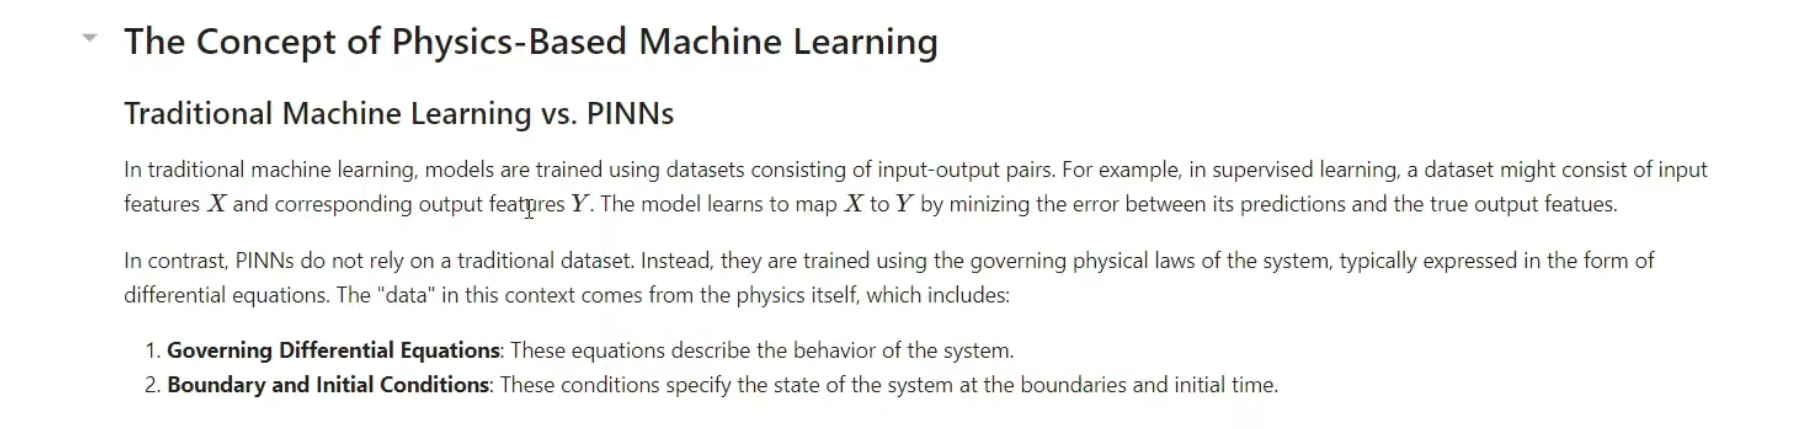

### Universal Approximation Theorem 


### According to universal Approximation Theorem neural network can learn to fit any dataset produced by complex function

## Neural Network Setup

### We design a simple neural network to approximate y(x). The input to the network will be spatial coordinate x, and the output will be the value of y at x. 

###                         y = yNN(x)
### where, yNN is the neural network

## Governing Differential Equations
### 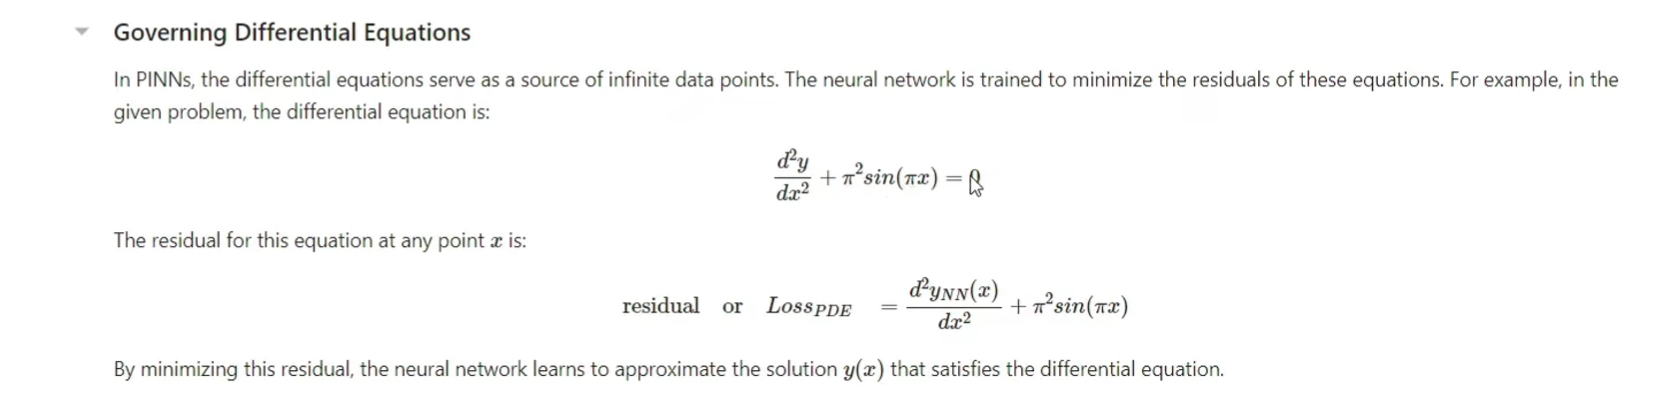
### The neural network is trained to reduce the error or residuals of this equation. 
### Now in second equation we will substitute the yNN in place of y. Ideally we expect output value to be zero, if it is not zero then there is an error and we approximate or reduce error to get better solutions 

## Boundary and Initial Condition
### 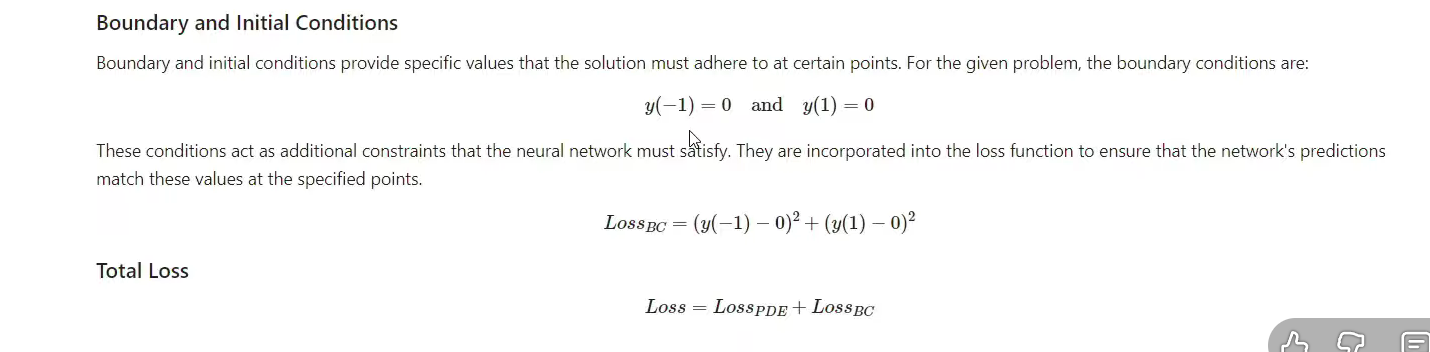

## Role of Collocation Points
### 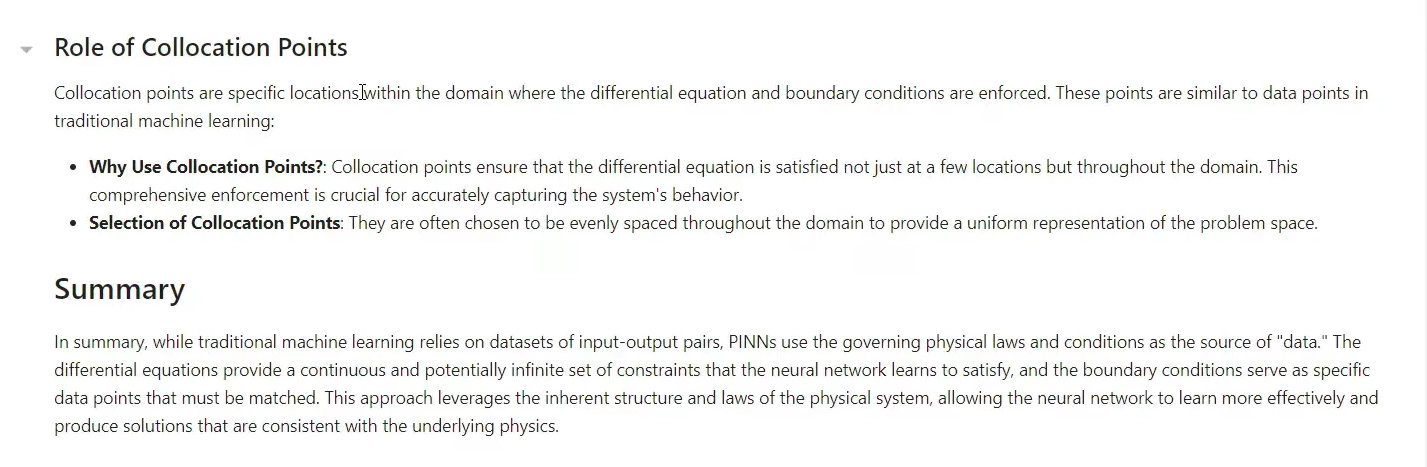

### Steps for NN
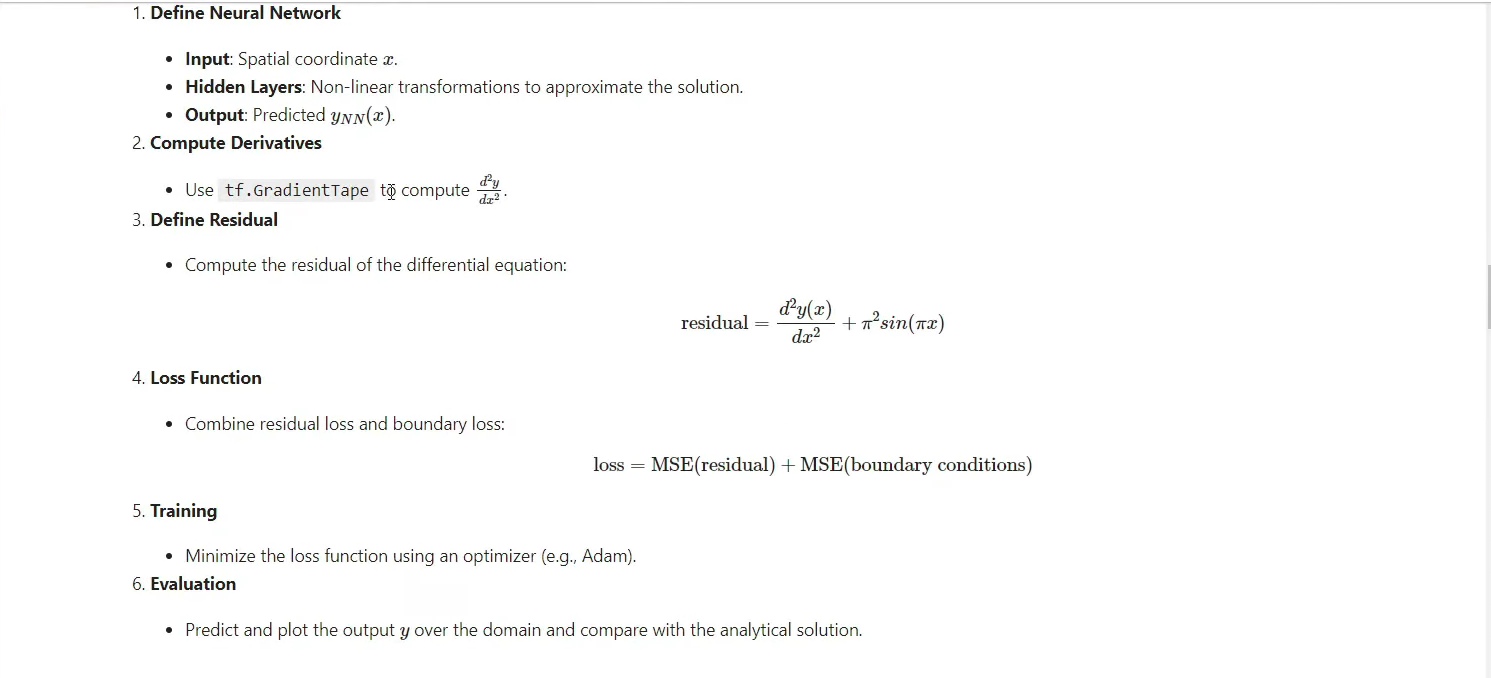

### Main Python Code

In [15]:
import numpy as np
import torch
from IPython.display import display
from PIL import Image
import torch.nn as nn # torch has nn lib 
import torch.nn.functional as F # will help us to move data forward
import matplotlib.pyplot as plt



In [16]:
class Model(nn.Module):
    def __init__(self, in_features = 1 , h1 = 50, h2 = 50, h3=50, out_features = 1):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)
        self.fc2 = nn.Linear(h1,h2)
        self.fc3 = nn.Linear(h2,h3)
        self.out = nn.Linear(h3,out_features)

        # THe above code connects all layers of neural network


    def forward(self,x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.out(x)

        return x
        # Using torch.tanh() or torch.nn.Tanh() is more common than F.tanh
        # this is used to forward data in each layer 
torch.manual_seed(41)
model = Model()


        

In [17]:
def pde(x,model):
    
    x.requires_grad_(True)
    y_pred = model(x)
    y_x = torch.autograd.grad(y_pred,x,grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    y_xx = torch.autograd.grad(y_x,x,grad_outputs=torch.ones_like(y_x), create_graph=True)[0]
   
    return y_xx + torch.pi**2*torch.sin(torch.pi *x)

# THis block is where physics part of code walks in, in this we double differentiate and solve 
# for the given PDE
    

In [18]:
def loss_func (model,x,x_bc,y_bc):
    res = pde(x,model) # To calculate residual that is how much models value is deviating from 0
    loss_pde = torch.mean(res**2)
    y_bc_pred = model(x_bc)
    loss_bc = torch.mean((y_bc - y_bc_pred)**2)
    
    return loss_pde + loss_bc

# Now our og PDE is supposed to have value of zero at each point. We calculate the value
# at each point using above function and then use MSE, to reduce the error
##  loss_pde --> THis code also measures the how far the model is from the following physics rule
## $y'' + \pi^2 \sin(\pi x) = 0$).
## loss_bc: Measures how far the model is from the "Boundary Conditions" (starting/ending points).
## loss_pde + loss_bc --> The model tries to minimize both at once.

In [19]:
def train_step (model,x,x_bc,y_bc,optimizer):
     
    optimizer.zero_grad() # Clears out the old math from the previous try.
    loss_value = loss_func(model,x,x_bc,y_bc) # Here we will get loss 
    loss_value.backward() # in this step using backpropagation and calculus the model will figure out which internal weights are causing most error
    optimizer.step() ## slightly adjust the weight to make error smaller next time
    return loss_value.item() ## Sends back the score as a simple number for us to read.

## This code is where the model improves itself

In [ ]:
## Setting up and Running
x_train = np.linspace(-1, 1, 100).reshape(-1, 1) ## Creates 100 points between -1 to 1 where model will practice physics
x_train = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)

x_bc = torch.tensor([[-1.0], [1.0]], dtype=torch.float32, requires_grad=True)
y_bc = torch.tensor([[0.0], [0.0]], dtype=torch.float32)

model = Model() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

epochs = 2000
for epoch in range(epochs):
    current_loss = train_step(model, x_train, x_bc, y_bc, optimizer)
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {current_loss:.6f}")

Epoch 0: Loss = 48.579956
Epoch 1000: Loss = 0.000337


In [ ]:
x_test = np.linspace(-1, 1, 1000).reshape(-1, 1)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

model.eval() 
with torch.no_grad():
    y_pred = model(x_test_tensor).numpy()

y_true = np.sin(np.pi * x_test)

# --- Plot the results ---
plt.figure(figsize=(10, 6))
plt.plot(x_test, y_true, 'b-', linewidth=2, label='Analytical Solution')
plt.plot(x_test, y_pred, 'r--', linewidth=2, label='PINN Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparison of Analytical Solution and PINN Solution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()